# pytorch beginer 用法

本文主要结合官方文档：[WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)，[VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)以及[pytorch/tutorials/beginner_source](https://github.com/pytorch/tutorials/tree/master/beginner_source) 中的[Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) 进一步了解pytorch的基本用法。

## 数据处理

很多时候要花时间在准备数据上，比如网络上下载的纯数据，想要顺利地输入到自己定义的模型中，可能这一步要花些时间来处理。

pytorch提供了许多工具来让数据的夹在更容易，来使代码可读性更强。接下来用一个例子看看如何加载并处理数据。

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

该数据集是一个面部图片。在这里下载：https://download.pytorch.org/tutorial/faces.zip ，解压后文件夹置于data文件夹下。

首先看看csv数据：

In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


展示一个图片看看：

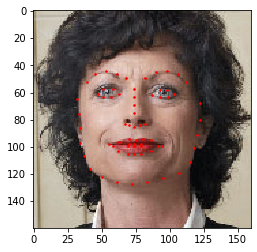

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

torch.utils.data.Dataset 是一个抽象类，代表一个数据集。自己定制的数据集应该继承Dataset 类，并重写__len__ 和__getitem__ 函数。前者是返回数据集的大小，后者用以支持索引dataset[i]来获取第i个sample。

现在为 face landmarks数据集**创建一个dataset类**。在 **__init__ 函数中读取csv文件**，将images的读取放在__getitem__中，这样可以避免一次性将所有数据都加载进内存。

设计数据集的sample为dict：{'image': image, 'landmarks': landmarks}，dataset会设置一个可选参数transform以在需要的时候作用到sample上。transform后面稍后再看。这里先说下基本逻辑，因为原始数据集可能有不同的格式，因此最好可以通过变换变换为统一的格式，因为__getitem__函数实际上是准备模型输入数据，所以transform函数在其中被调用。

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

现在初始化类并迭代数据samples，以4个samples为例：

0 (324, 215, 3) (68, 2)


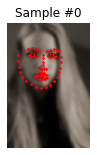

1 (500, 333, 3) (68, 2)


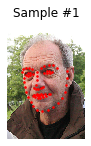

2 (250, 258, 3) (68, 2)


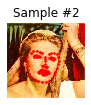

3 (434, 290, 3) (68, 2)


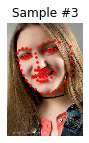

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

从上面的图片中可以看出samples大小是不一样的。而神经网络还是希望输入的数据是大小fixed的，所以需要对数据做预处理：

- Rescale: scale 图片
- RandomCrop: 随机切图. 这是 data augmentation.
- ToTensor: 将numpy的images转换为torch images(需要swap axes).

将它们都写为**可调用的class**，而不是简单的需要在调用时传参的函数。需要实现__call__方法，还有如有需要的__init__函数。然后就可以形如下列模式，直接像函数一样调用对象了：

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

注意看看这些transforms如何应用到images和landmarks上：

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

现在将transform 应用到一个sample上。比如我们想rescale image的较短边到256，并随机切成一个边长224的正方形，所以要使用Rescale 和RandomCrop 变换。torchvision.transforms.Compose 是自带的一个可以执行这些变换的。

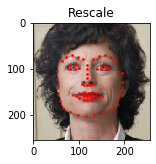

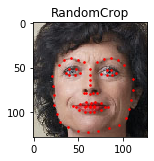

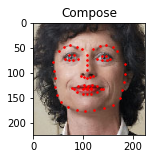

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

现在我们可以应用前面所述工具创建一个转换后的数据集了：

- 快速读取image
- 转换读取的image
- 因为数据转换是随机的，所以数据是增强的

迭代读取数据，在创建Dataset实例时，赋值transform类实例，这样后面调用__getitem()__ 获取模型输入数据时，就会执行变换。

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


不过，由于只是简单地迭代数据，因此我们丢失了很多特征。比如：

- Batching 数据
- Shuffling 数据
- 使用multiprocessing 并行加载数据

torch.utils.data.DataLoader是一个迭代器，能提供上述功能。我们必须得清楚一些参数。其中之一是collate_fn。可以指定样本需要如何被batched。大多数情况下默认的方式即可。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


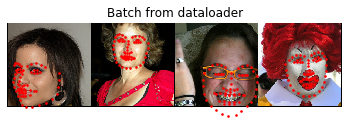

In [10]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True)  # if multi-core cpu ： num_workers=4


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

最后再根据网上查的资料总结下dataset，dataloader等的用法。参考资料有：[Pytorch数据读取(Dataset, DataLoader, DataLoaderIter)](https://zhuanlan.zhihu.com/p/30934236),[一文弄懂Pytorch的DataLoader, DataSet, Sampler之间的关系](https://www.cnblogs.com/marsggbo/p/11308889.html),[PyTorch 中自定义数据集的读取方法小结](https://www.pytorchtutorial.com/pytorch-custom-dataset-examples/)

Pytorch的数据读取非常方便, 可以很容易地实现多线程数据预读，而且编程难度不大，灵活性也更高。Pytorch的数据读取主要包含三个类:

- Dataset
- DataLoader
- DataLoaderIter

这三者大致是一个依次封装的关系: 1.被装进2., 2.被装进3.

torch.utils.data.Dataset是一个抽象类, 自定义的Dataset需要继承它并且实现两个成员方法:

- __getitem__()
- __len__()

第一个最为重要, 即每次怎么读数据，比如对于一个图片：

```python
def __getitem__(self, index):
    img_path, label = self.data[index].img_path, self.data[index].label
    img = Image.open(img_path)

    return img, label
```

可以看到，img是模型训练的输入数据，label是模型训练的输出数据。

第二个比较简单, 就是返回**整个数据集的长度**，比如：

```python
def __len__(self):
    return len(self.data)
```

torch.utils.data.DataLoader类定义为:

```python
class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)
```

可以看到, 主要参数有这么几个:

- dataset : 即上面自定义的dataset.
- collate_fn: 这个函数用来打包batch, 后面详细讲.
- num_worker: 非常简单的多线程方法, 只要设置为>=1, 就可以多线程预读数据啦.

这个类一共干了两件事: 

1. 定义了一堆成员变量, 到时候赋给torch.utils.data.dataloader.DataLoaderIter 
2. 然后有一个__iter__() 函数, 把自己 "装进" DataLoaderIter 里面.

```python
def __iter__(self):
    return DataLoaderIter(self)
```

现在再自上而下理解下，首先看看DataLoader.__next__ 的源码：

```python
class DataLoader(object):
    ...
    
    def __next__(self):
        if self.num_workers == 0:  
            indices = next(self.sample_iter)  # Sampler
            batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset
            if self.pin_memory:
                batch = _utils.pin_memory.pin_memory_batch(batch)
            return batch
```

稍微解读下这段代码：

首先 indices = next(self.sample_iter) 这句，假设我们的数据是一组图像，每一张图像对应一个index，那么如果我们要读取数据就只需要**对应的index**即可，即代码中的indices,而选取index的方式有多种，有按顺序的，也有乱序的，所以这个工作需要Sampler完成，所以DataLoader和Sampler在这里产生了关系。说白点，就是sampler去选择要哪些数据，假如指定了shuffle=True，那就不必再自己定义sampler了，就是直接打乱取样了，indices就会被shuffle好的。

然后Dataset和DataLoader在什么时候产生关系呢？就是这句：“batch = self.collate_fn([self.dataset[i] for i in indices]) # Dataset”。[self.dataset[i] for i in indices] 将选中的数据集拼到一个list里面，然后利用 collate_fn 将这个list的数据组织成想要的 batch 的形式。collate_fn 可以使用默认的，也可以自己写一个。default_collate （在torch.utils.data.\_utils.collate.py中） 注释是：r"""Puts each data field into a tensor with outer dimension batch size""" ， 也就是说batch_size 是最外部的维度。

所以有这样的关系图：

![](g79zz9rukh.png)

DataLoader 的源代码如下：

```python
class DataLoader(object):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, collate_fn=default_collate,
                 pin_memory=False, drop_last=False, timeout=0,
                 worker_init_fn=None)
```

可以看到初始化参数里有两种sampler：sampler和batch_sampler，都默认为None。前者的作用是**生成一系列的index**，而**batch_sampler则是将sampler生成的indices打包分组，得到一个又一个batch的index**。例如下面示例中，BatchSampler将 **SequentialSampler生成的index** **按照指定的batch size分组**。

In [5]:
from torch.utils.data.sampler import BatchSampler
from torch.utils.data.sampler import SequentialSampler
list(BatchSampler(SequentialSampler(range(10)), batch_size=3, drop_last=False))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

Pytorch中已经实现的Sampler有如下几种：

- SequentialSampler
- RandomSampler
- WeightedSampler
- SubsetRandomSampler

需要注意的是DataLoader的部分初始化参数之间存在互斥关系，这里做些总结：

- 如果你自定义了batch_sampler,那么这些参数都必须使用默认值：batch_size, shuffle,sampler,drop_last.
- 如果你自定义了sampler，那么shuffle需要设置为False
- 如果sampler和batch_sampler都为None,那么batch_sampler使用Pytorch已经实现好的BatchSampler,而sampler分两种情况：
    - 若shuffle=True,则sampler=RandomSampler(dataset)
    - 若shuffle=False,则sampler=SequentialSampler(dataset)
    
Dataset定义方式前面已说，就不再赘述，总之 __getitem__ 是最主要的方法，它规定了如何读取数据，它是python built-in方法，其主要作用是能让该类可以像list一样通过索引值对数据进行访问。假如你定义好了一个dataset，那么你可以直接通过dataset[0]来访问第一个数据。如果你想对__getitem__方法进行调试，你可以写一个for循环遍历dataset来进行调试了，而不用构建dataloader等一大堆东西了。DataLoader对数据的读取其实就是**用了for循环来遍历数据**。

self.collate_fn方法的参数中：

- indices: 表示每一个iteration，sampler返回的indices，即一个batch size大小的索引列表
- self.dataset[i]: 前面已经介绍了，这里就是对第i个数据进行读取操作，一般来说self.dataset[i]=(img, label)

看到这不难猜出collate_fn的作用就是**将一个batch的数据进行合并操作**。默认的collate_fn是将img和label分别合并成imgs和labels，所以如果你的__getitem__方法只是返回 img, label，那么你可以使用默认的collate_fn方法，但是如果你每次读取的数据有img, box, label等等，那么你就需要自定义collate_fn来将对应的数据合并成一个batch数据，这样方便后续的训练步骤。

最后总结下最简单地使用基本过程，参考：[批训练](https://morvanzhou.github.io/tutorials/machine-learning/torch/3-05-train-on-batch/)

Torch 中提供了一种帮你整理你的数据结构的好东西, 叫做 DataLoader, 我们能用它来包装自己的数据, 进行批训练. 

DataLoader 是 torch 给你用来包装你的数据的工具. 所以你要将自己的 (numpy array 或其他) 数据形式**装换成 Tensor, 然后再放进这个包装器中**. 使用 DataLoader 有什么好处呢? 就是他们帮你有效地迭代数据, 举例如下。其中注释给出了关键步骤。

In [7]:
import torch
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible

BATCH_SIZE = 5      # 批训练的数据个数

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(x, y)

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

Epoch:  0 | Step:  0 | batch x:  [ 5.  7. 10.  3.  4.] | batch y:  [6. 4. 1. 8. 7.]
Epoch:  0 | Step:  1 | batch x:  [2. 1. 8. 9. 6.] | batch y:  [ 9. 10.  3.  2.  5.]
Epoch:  1 | Step:  0 | batch x:  [ 4.  6.  7. 10.  8.] | batch y:  [7. 5. 4. 1. 3.]
Epoch:  1 | Step:  1 | batch x:  [5. 3. 2. 1. 9.] | batch y:  [ 6.  8.  9. 10.  2.]
Epoch:  2 | Step:  0 | batch x:  [ 4.  2.  5.  6. 10.] | batch y:  [7. 9. 6. 5. 1.]
Epoch:  2 | Step:  1 | batch x:  [3. 9. 1. 8. 7.] | batch y:  [ 8.  2. 10.  3.  4.]


当数据是高维时，也没有问题，比如二维的情况，参考：[How to load a list of numpy arrays to pytorch dataset loader?](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader)

In [1]:
import torch
import numpy as np
from torch.utils import data

my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = data.DataLoader(my_dataset) # create your dataloader
for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(my_dataloader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

Epoch:  0 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  0 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]
Epoch:  1 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  1 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]
Epoch:  2 | Step:  0 | batch x:  [[[1. 2.]
  [3. 4.]]] | batch y:  [[4.]]
Epoch:  2 | Step:  1 | batch x:  [[[5. 6.]
  [7. 8.]]] | batch y:  [[2.]]


再比如三维，参考：[Input numpy ndarray instead of images in a CNN](https://discuss.pytorch.org/t/input-numpy-ndarray-instead-of-images-in-a-cnn/18797)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np


class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


numpy_data = np.random.randn(100, 3, 24, 24)
numpy_target = np.random.randint(0, 5, size=(100))

dataset = MyDataset(numpy_data, numpy_target)
loader = DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
#     num_workers=2,   # 如果有GPU， 可以取消这两行注释
#     pin_memory=torch.cuda.is_available()
)

for batch_idx, (data, target) in enumerate(loader):
    print('Batch idx {}, data shape {}, target shape {}'.format(
        batch_idx, data.shape, target.shape))

Batch idx 0, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 1, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 2, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 3, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 4, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 5, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 6, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 7, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 8, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])
Batch idx 9, data shape torch.Size([10, 3, 24, 24]), target shape torch.Size([10])


不过要注意关键是如何使用loop送入模型训练，读取的数据的形式一定要能和模型所需的输入匹配。

接下来参考：[Building Efficient Custom Datasets in PyTorch](https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f)，给出一个完整的各种类型数据的示例，这个例子是处理文本文件制作数据集，利用Dataset和Dataloader。

## Tensorboard

可以展示模型训练时的一些统计指标以对训练过程有基本的认识。Pytorch现在整合了TensorBoard，它是一个设计来可视化神经网络训练过程结果的工具。有了它可以可视化更丰富的内容。tensorboard 是pytorch官方推荐的工具，它来自tensorflow的可视化工具箱。可以参考：[TensorBoard: TensorFlow's visualization toolkit](https://www.tensorflow.org/tensorboard/)，查看更多细节。其基本功能包括以下内容等：

- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data

另外，根据[Welcome to tensorboardX’s documentation!](https://tensorboardx.readthedocs.io/en/latest/index.html) 介绍，pytorch中应是使用的tensorboradx来作为调用tensorboard的工具。

接下来是一个例子，首先读取数据并做合适的变换。接着**设置tensorboard并将数据写入tensorboard**，然后就可以使用tensorboard了，包括查看训练数据，跟踪模型训练性能，以及评估训练后的模型性能。

In [11]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

# 注意test时候的dataloader是不用shuffle的。
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

26427392it [00:01, 13368522.49it/s]                             


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


32768it [00:00, 84290.76it/s]                            


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


4423680it [00:01, 3457450.37it/s]                            


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw


8192it [00:00, 33182.46it/s]            


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw
Processing...
Done!


以上是数据的前处理，接下来构建网络模型：

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

建立event writer 实体在纪录任何东西之前，我们需要**建立一个event writer 实体**，具体而言就是开始设置tensorboard时，先从torch.utils导入并定义**SummaryWriter**，这是向tensorboard写数据的关键对象，SummaryWriter 是一个类别，包含tensorboard套件的所有功能。 runs/fashion_mnist_experiment_1 是一个被建立的文件夹，TensorBoard 对象会被放入其中。接下来要写入任何资料都是**调用writer.add_xxx()**，xxx表示某功能。

注意子目录 fashion_mnist_experiment_1。每个子目录都会被视为一个实验。每次执行新的实验时，比如说改了一些参数，这时请将资料夹重新命名，像是：runs/exp2, runs/myexp这样可以便于比较实验的结果。

建立writer实体之后就可以开始纪录了，API的长相大概是：add_xxx(标签，要記錄的東西，時間戳，其他參數)。更多内容可以参考：[Tutorials_zh](https://tensorboardx.readthedocs.io/en/latest/tutorial_zh.html)

如果你的pytorch版本是1.1, 1.2，那么需要手动安装tensorboard，如果更低版本，那么建议升级吧。安装tensorboard的方法可以参考：[Using TensorBoard with PyTorch 1.1 or 1.2](https://www.endtoend.ai/blog/pytorch-tensorboard/)。如果使用了pipenv，也可以使用pipenv安装。注意报错的话，详细查看文中的安装细节。比如我遇到的错误：ModuleNotFoundError: No module named 'past'，然后安装future： pipenv install future 即可。

In [13]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

创建了新的文件夹runs/fashion_mnist_experiment_1之后，接下来把数据写入 TensorBoard，因为这里是图片，所以使用make_grid 。

其实最直接的还是记录純数据量，其方法是 writer.add_scalar('myscalar', value, iteration)， value 可以是 PyTorch tensor ， numpy或是 float，int 之類的python原生數字類別。稍后在训练过程中有记录。这里先看图片。

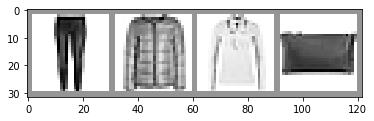

In [14]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

现在在本文件夹下打开命令行并运行：

```Shell
tensorboard --logdir=runs
```

然后就可以导航到 https://localhost:6006 查看交互式图形了。

tensorboard的一个亮点是能可视化复杂的模型结构。它需要两个参数：神经网络模型 以及 你要喂给他的 tensor，令模型為 m，輸入為 x，則使用方法為： add_graph(m, (x, )) 這裡使用 tuple 的原因是當网络有多個輸入時，可以把他擴充成 add_graph(m, (x, y, z)) ，如果只有單一輸入，寫成 add_graph(m, x) 也無妨。注意如果輸入是 cpu tensor，model 在 GPU 上，或者反过来，那么该函数就会报错。

In [16]:
writer.add_graph(net, images)
writer.close()

执行完上面命令后，刷新TensorBoard，就会看到网页导航栏有“GRAPHS”。点击进入，就能看到模型结构，双击每个节点，就能看到内部的结构。

接下来看看如何通过add_embedding方法来可视化高维数据为低维表示。

In [17]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

接下来将loss记录进TensorBoard，并通过plot_classes_preds函数看模型预测。首先是一些辅助函数：

In [18]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

然后训练模型，并使用add_scalar函数将结果写入TensorBoard，而不是输出到控制台。前面已经提到过记录纯数据的add_scalar函数了，这里稍微展开一点。

純数据量是最好記錄的東西。通常我們會把每次訓練的損失loss記錄下來或者是測試的準確度accuracy，都是值得記錄的東西。其他數據，像是學習率learning rate也值得紀錄。 紀錄纯数据的方法是 writer.add_scalar('myscalar', value, iteration)， value 可以是 PyTorch tensor ， numpy或是 float，int 之類的python原生數字類別。

另外就是绘制图表，用 matplotlib 畫了美美的圖表想紀錄？請用 add_figure 。傳入的对象是 matplotlib 的 figure。

In [19]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


现在在SCALARS标签下可以看到训练过程中loss的变化。最后可以看看如何评估模型。在新的标签页可以看到结果。

In [10]:
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

## 模型保存和加载

这部分主要参考官方文档；[SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)，pytorch中有三个核心函数和模型保存及加载有关。

- torch.save: 保存一个序列化的对象到disk中。该函数使用了 Python’s pickle 功能来实现序列化. 使用该函数可以保存 Models, tensors, and dictionaries of all kinds of objects
- torch.load: 使用了 pickle’s unpickling 功能来反序列化 pickled object files 到内存中.该函数还支持跨设备加载数据，后面有记录.
- torch.nn.Module.load_state_dict: 用反序列化的 state_dict 加载 model’s parameter dictionary. 关于 state_dict, 接下来会记录相关内容。

首先看看什么是state_dict。

在pytorch中，torch.nn.Module 模型的可学习参数在 model’s parameters 存放，通过model.parameters() 可以访问。state_dict 就是一个简单的python 字典数据对象，将每层都对应到它的参数张量中。注意仅仅是有可学习参数的层以及registered buffers（batchnorm’s running_mean）有state_dict的项。  Optimizer objects (torch.optim)也有state_dict，它包含了optimizer’s 状态的信息以及使用的超参数。

接下来是一个例子：

In [20]:
# Define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [2377417183864, 2377417244904, 2377417245064, 2377552715272, 2377515008072, 2377552715352, 2377552715432, 2377552715512, 2377552715592, 2377552715672]}]


可以看到在model 和 optimizer 中，各有一个state_dict。接下来看看如何保存和加载模型。

Save/Load state_dict 是官方文档推荐的做法。

保存:

```python
torch.save(model.state_dict(), PATH)
```

加载：

```python
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

保存模型时，保存模型的可学习参数就足够了。使用torch.save保存模型可以给加载模型提供足够的灵活度，保存的文件的后缀名约定一般是.pt 或者 .pth

注意一定要调用 model.eval() 来设置dropout和batch normalization层 以在运行推断前评估模型。忘记做这个会导致不一致的结果。

pytorch也提供了直接保存和加载整个模型的功能：

保存：

```python
torch.save(model, PATH)
```

加载：

```python
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()
```

这种方法的缺点是保存模型时将序列化的数据绑定到使用的特定类和精确的目录结构，这样做的原因是pickle并不保存模型类本身，相反，它保存了包含类的文件的路径，在加载时使用。因此，在其他项目中使用或重构之后，您的代码可能会以各种方式中断。总之，就是换换文件夹有可能报错。

## 跟着例子学习PyTorch

通过例子了解pytorch的基本概念。

PyTorch的核心是提供两个主要功能：

- n维张量，类似于numpy，但可以在GPU上运行；
- 自动区分以构建和训练神经网络。

### 张量

首先，温习下Numpy。 numpy提供了一个n维的数组对象, 并提供了许多操纵这个数组对象的函数。Numpy 是科学计算的通用框架; Numpy 数组没有计算图, 也没有深度学习, 也没有梯度下降等方法实现的接口。但是可以很容易地使用 numpy 生成随机数据，并将产生的数据传入双层的神经网络,并实现这个网络的正向传播和反向传播。下面是一个numpy实现的两层神经网络：

In [2]:
import numpy as np

# N是批尺寸参数；D_in是输入维度
# H是隐藏层维度；D_out是输出维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 产生随机输入和输出数据
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# 随机初始化权重
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(10): # 可以多设代数
    # 前向传播：计算预测值y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # 计算并显示loss（损失）
    loss = np.square(y_pred - y).sum()
    print(t, loss)

    # 反向传播，计算w1、w2对loss的梯度
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # 更新权重
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 47210584.421595454
1 52147870.419683054
2 57742749.7018303
3 48678706.12763923
4 27685925.824841775
5 11067765.22382442
6 4462490.630094571
7 2432642.970467399
8 1722643.7375642802
9 1364839.1587514523


简单分析下上面的计算，$loss=\sum _i^n (y_{predict_i}-y_i)^2$，所以$\frac{\partial{loss}}{\partial{y_{predict_i}}}=2(y_{predict_i}-y_{i})$，所以对于向量y_pred的梯度，有：grad_y_pred = 2.0 * (y_pred - y)，同理可以依次推求各个梯度，比如$y_{predict_i}=\sum _i^n h\_relu_i * w2_i$，所以$\frac{\partial{loss}}{\partial{w2_i}}=\frac{\partial{loss}}{\partial{y_{predict_i}}} * \frac{\partial{y_{predict_i}}}{\partial{w2_i}}$，而$\frac{\partial{y_{predict_i}}}{\partial{w2_i}}=h\_relu_i$，所以转换成向量：有grad_w2 = h_relu.T.dot(grad_y_pred)。更正式点的推导可以参考：[一个简单两层网络的演变](https://blog.csdn.net/StreamRock/article/details/83718443)。

首先，把前向传播和loss函数数学表达式写好。然后可以先考虑一个样本的后向计算。后向计算中麻烦点的就是矩阵求导，这部分可以参考：[向量的2范数求导？](https://www.zhihu.com/question/31845977),还有[Matrix calculus](https://en.wikipedia.org/wiki/Matrix_calculus). 公式不好码，这里就不多说了。

Numpy 是一个伟大的框架, 但它不能利用 GPU 加速它数值计算，而对于现代的深度神经网络, GPU 往往是提供 50倍或更大的加速,所以 numpy 不足以满足现在深度学习的需求。

PyTorch提供了Tensor，其在概念上与 numpy 数组相同，也是一个n维数组, 不过PyTorch 提供了很多能在这些 Tensor 上操作的函数。

任何numpy 数组的操作都可以在 PyTorch Tensor 上开展。另外不像 numpy, PyTorch Tensor 可以利用 GPU 加速他们的数字计算。

要在 GPU 上运行 PyTorch 张量, 只需将其转换为新的数据类型. 下面就像上面的 numpy 例子一样, 将 PyTorch Tensor 生成的随机数据传入双层的神经网络, 手动实现网络的正向传播和反向传播:

In [3]:
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device)
w2 = torch.randn(H, D_out, device=device)

learning_rate = 1e-6
for t in range(10):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss; loss is a scalar, and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python number with loss.item().
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 28328694.0
1 26614422.0
2 30046522.0
3 34163608.0
4 34199284.0
5 27548846.0
6 17430478.0
7 9046773.0
8 4364270.0
9 2210282.75


### 自动求导

对于小型的两层网络而言，手动实现反向传递并不重要，但对于大型的复杂网络而言，这变得非常麻烦。

幸运的是，我们可以使用**自动微分** 来自动计算神经网络中的反向传播。PyTorch中的 autograd软件包提供了这个功能。使用autograd时，网络 在正向传递时将定义一个 计算图；图中的节点为张量，图中的边为从输入张量产生输出张量的函数。通过该图进行反向传播，可以轻松计算梯度。计算图的相关内容可以复习2.1-60min-pytorch了解。

这听起来很复杂，在实践中非常简单。**每个张量代表计算图中的一个节点**。如果 x是一个张量，并且有 x.requires_grad=True，那么x.grad就是另一个张量，代表着x相对于某个标量值的梯度（这里有点容易理解错，下面看例子就ok了）。

有时候可能不需要pytorch自动构建计算图，比如反向传播的时候，我们不想更新权重也进入计算图（因为它不是前向计算的内容），这时候可以使用 torch.no_grad()来阻止计算图的构建。

通过使用PyTorch张量和autograd来实现网络就不再需要手动实现网络的反向传播：

In [4]:
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for t in range(10):
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
  
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_()
        w2.grad.zero_()

0 26639924.0
1 20806696.0
2 20385932.0
3 22464084.0
4 24744818.0
5 24688410.0
6 21053018.0
7 14962570.0
8 9134588.0
9 5084152.0


来看看loss.backward()具体都做了什么。在一次epoch，即一次循环中，计算图已经从x，结合w1和w2，构建到y_pred，然后又结合y构建到loss，这里面w1，w2，y_pred和loss的grad都是有的。因为是反向传播，因此计算图计算的w1.grad 就是$\frac{\partial{loss}}{\partial{w1}}$（计算图的相关内容可以复习2.1-60min-pytorch了解）。

然后注意最后的with语句，with是指操作的上下文环境，因为是更新权重，不要进入计算图，因此在torch.no_grad()环境下运算。最后要手动地将w1的梯度置零，让下一个epoch重新计算。至于为什么默认是没清零的，可以看看2.1-60min-pytorch中的内容。

### 定义新的autograd函数

在底层，每一个原始的**自动求导运算**实际上是**两个在Tensor上运行的函数**。其中，**forward**函数计算从输入Tensors获得的输出Tensors。而**backward**函数接收输出Tensors对于某个标量值的梯度，并且计算输入Tensors相对于该相同标量值的梯度。

在PyTorch中，可以很容易地通过定义**torch.autograd.Function**的子类并实现**forward和backward函数**，来**定义自己的自动求导运算**。然后，我们可以通过**构造实例**并**像调用函数一样调用它**，并传递包含输入数据的张量。

接下来一个例子定义一个自己的定制autograd函数来执行ReLU，并用它来实现一个两层神经网络。

可以看到首先继承了torch.autograd.Function类。

重写的forward函数接受一个包含input的tensor并返回一个包含输出的tensor。ctx是一个context对象，可以用来为 backward 计算保存信息。您可以使用  ctx.save_for_backward 方法缓存任意对象，以便在 后面 backward 传递中使用。clamp函数就是类似ReLU形式的函数，min=0 就是ReLU。所以前向计算就是在最后这步计算ReLU，然后记得要把input放入计算图。

在backward传递中，我们得到一个张量，它包含了loss相对于**输出**的梯度，我们需要计算loss相对于**输入**的梯度。首先注意backward只是计算梯度，并不更新权重！ReLU的反向梯度是怎么算的前面复习numpy的时候已经有过介绍了，注意这里grad_output是output的梯度，即$\frac{\partial{loss}}{\partial{output}}$，所以根据链式法则，我们计算$\frac{\partial{loss}}{\partial{input}}=\frac{\partial{loss}}{\partial{output}} \frac{\partial{output}}{\partial{input}}$，而$\frac{\partial{output}}{\partial{input}}$就是对ReLU函数求导，就是非零的时候为1，零的时候为0。所以有 grad_output[input < 0] = 0，grad_output已经赋值到grad_input，所以有grad_input[input < 0] = 0

In [5]:
# Code in file autograd/two_layer_net_custom_function.py
import torch

class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, x):
        """
        In the forward pass we receive a context object and a Tensor containing the
        input; we must return a Tensor containing the output, and we can use the
        context object to cache objects for use in the backward pass.
        """
        ctx.save_for_backward(x)
        return x.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive the context object and a Tensor containing
        the gradient of the loss with respect to the output produced during the
        forward pass. We can retrieve cached data from the context object, and must
        compute and return the gradient of the loss with respect to the input to the
        forward function.
        """
        x, = ctx.saved_tensors
        grad_x = grad_output.clone()
        grad_x[x < 0] = 0
        return grad_x


device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and output
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Create random Tensors for weights.
w1 = torch.randn(D_in, H, device=device, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, requires_grad=True)

learning_rate = 1e-6
for t in range(10):
    # Forward pass: compute predicted y using operations on Tensors; we call our
    # custom ReLU implementation using the MyReLU.apply function
    y_pred = MyReLU.apply(x.mm(w1)).mm(w2)
 
    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    with torch.no_grad():
        # Update weights using gradient descent
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_()
        w2.grad.zero_()

0 29388140.0
1 23344078.0
2 20084176.0
3 17090222.0
4 13747746.0
5 10321166.0
6 7316202.5
7 5010261.0
8 3402158.0
9 2342496.5


简单分析下上面这段代码。 MyReLU.apply 将函数作用到前向计算中，现在计算图中有梯度的变量：w1，w2，y_pred，loss ，和之前一样。注意MyReLU中同时定义了前向后向计算。

为了更清楚地理解backward函数的意义，这里补充一些参考：[探讨pytorch中nn.Module与nn.autograd.Function的backward()函数](https://cloud.tencent.com/developer/article/1149993).

backward()在pytorch中是一个经常出现的函数，我们一般会在更新loss的时候使用它，比如loss.backward()。通过对loss进行backward来实现从输出到输入的自动求梯度运算。对该函数溯源下可以发现这个backward来源于torch.autograd.backward。这个函数我们可能不常见，那么这个函数在哪儿呢，就在Tensor这个类中（loss就是一个tensor），而**Tensor这个类中有一个函数：backward()函数**。这个函数**返回的就是torch.autograd.backward()**。也就是说，我们在训练中输入我们数据，然后经过一系列神经网络运算，最后计算loss，然后loss.backward()。这里的backward()归根究底就是，上面说的这个函数。

好，那么接下来就说明两个backward，一个nn.Module中的backward()，一个torch.autograd.Function中的backward()，其实有一个是假的backward()。

很容易发现，我们在自己定义一个全新的网络层的时候会**继承nn.Module**，但是我们只需要实现__init__和forward()即可，不需要实现也**没必要实现backward()函数**。即使你实现了，你继承了nn.Module并且编写了一个backward()函数，在实际运行中该backward函数也并不会执行。这就是假的backward函数，不会在pytorch的自动求梯度图中执行。因为目的是要实现对loss的backward，在forward中进行操作的时候，已经对torch.autograd.Function的subclass进行了操作。也就是说在我们**对tensor进行每一步操作运算的时候都会生成一个Function类的子类，里面定了好了forward和backward操作**，最后连成**计算图**.

那既然不建议在nn.Module中定义backward。那能不能自己定义backward函数？

可以通过**继承torch.autograd.Function来定义**！官方教程：[PyTorch: Defining new autograd functions](https://github.com/jcjohnson/pytorch-examples#pytorch-defining-new-autograd-functions)，这就是上面的例子。MyReLU继承了torch.autograd.Function。那么我们在什么情况下需要自己定义？

平常使用的nn.Module其实说白了就是一层包装(Contain)，比如nn.Conv2继承了nn.Module，但是里面的核心函数是torch.nn.function.conv2d，为什么要包装下，原因很简单，**为了方便**，因为我们使用的卷积层是有参数的，这些参数是可以学习的(learnable parameters)。在这个包装类中我们通过torch.nn.parameter的Parameter类把参数进行包装然后传递给torch.nn.function中的函数进行计算，这样也就简化了我们的操作。

那么什么时候需要使用torch.autograd.Function去定义自己的层，在**有些操作通过组合pytorch中已有的层实现不了的时候**，比如你要实现一个新的梯度下降算法，那么就可以尝试着写这些东西。但是要注意，因为这个涉及到了底层，你需要forward和backward一起写，然后自己写对中间变量的操作，比如gradinput以及gradoutput。比如：

```python
class my_function(Function):
    def forward(self, input, parameters):
        self.saved_for_backward = [input, parameters]
        # output = [对输入和参数进行的操作，这里省略]
        return output

    def backward(self, grad_output):
        input, parameters = self.saved_for_backward
        # grad_input = [求 forward(input)关于 parameters 的导数] * grad_output
        return grad_input

# 然后通过定义一个Module来包装一下

class my_module(nn.Module):
    def __init__(self, ...):
        super(my_module, self).__init__()
        self.parameters = # 初始化一些参数

    def backward(self, input):
        output = my_function(input, self.parameters) # 在这里执行你之前定义的function!
        return output
```

这样你就可以通过自定义层然后包装，然后来使用了。包不包装对于执行效率的影响几乎可以不计。

然后再补充下关于ctx的内容。参考了：[About the value of CTX](https://discuss.pytorch.org/t/about-the-value-of-ctx/16821)，[Difference between 'ctx' and 'self' in python?](https://stackoverflow.com/questions/49516188/difference-between-ctx-and-self-in-python)。

ctx是context，上下文，这里是Function运行的上下文。如果forward函数只包含helper函数，那么ctx是空的。

相同的ctx会被传给backward函数，所以可以**使用它来存储一些东西以在backward的时候使用**。它和python类的self参数有些相似。区别在于重写torch.nn.Module的forward函数时，这不是staticmethod，但是继承autograd的function时，这是staticmethod。

A static method (@staticmethod) is called using the class type directly, not an instance of this class，比如:LinearFunction.backward(x, y)

因为没有类的实例，所以静态方法中self就没有意义，而**ctx是一个普通参数，可以在调用静态方法的时候传递**。

此外，还有几个函数也比较特别：比如mark_dirty()，参考：[Understand mark_dirty()](https://discuss.pytorch.org/t/understand-mark-dirty/303)。

首先补充下pytorch中的in-place运算。参考：[Memory efficient pytorch](https://www.slideshare.net/HyungjooCho2/memory-efficient-pytorch)。原地计算，输入会被输出覆盖，比如通过替换元素更新输入。

比如a=a.add(1)是out-place的，而a.add_(1)是in-place的，a+=1也是in-place的。尾部带下划线的是in-place计算。

如果在做in-place原地运算，并且还会在原来的tensor执行，backward可能会有错。比如：有$y = x^2 z = x^2$，如果对第二个公式执行了z = x.pow_(2)原地计算，x是一个张量，那么就不能计算第一个公式的backward了。

所有的张量上，pytorch有一个内部版本计数器来跟踪这些东西，make_dirty可以确保此版本计数器已正确计算。如果用户执行的操作无法正确计算backward，则会抛出错误。dirty就是数据库中那个脏数据差不多的意思。

### Tensorflow：静态图

Pytorch和tensorflo很像，都是定义计算图，并使用自动微分进行梯度计算。最大的区别在于pytorch是构建动态计算图。

在Tensorflow中，定义一次计算图之后，就不变了。而在pytorch中，每一次前向计算都会定义新的计算图。静态图很好，因为可以预先优化图，比如可以设计分配计算图到GPU的策略。如果反复使用相同的图，那么这种潜在的昂贵的预先优化可以在反复运行相同的图时进行摊销。

静态图和动态图的一个区别是控制流。对于某些模型，我们可能希望对每个数据点执行不同的计算;例如，可以对每个数据点的不同时间步长展开一个递归网络;这种展开可以作为一个循环来实现。对于静态图，循环结构需要成为图的一部分;因此，TensorFlow提供了tf.scan等操作符，将循环嵌入图中。对于动态图，情况更简单:因为我们为每个示例动态构建图，所以我们可以使用普通的命令式流控制来执行不同输入的计算。tensorflow是这样构建图的：

In [ ]:
import tensorflow as tf
import numpy as np

# First we set up the computational graph:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create placeholders for the input and target data; these will be filled
# with real data when we execute the graph.
x = tf.placeholder(tf.float32, shape=(None, D_in))
y = tf.placeholder(tf.float32, shape=(None, D_out))

# Create Variables for the weights and initialize them with random data.
# A TensorFlow Variable persists its value across executions of the graph.
w1 = tf.Variable(tf.random_normal((D_in, H)))
w2 = tf.Variable(tf.random_normal((H, D_out)))

# Forward pass: Compute the predicted y using operations on TensorFlow Tensors.
# Note that this code does not actually perform any numeric operations; it
# merely sets up the computational graph that we will later execute.
h = tf.matmul(x, w1)
h_relu = tf.maximum(h, tf.zeros(1))
y_pred = tf.matmul(h_relu, w2)

# Compute loss using operations on TensorFlow Tensors
loss = tf.reduce_sum((y - y_pred) ** 2.0)

# Compute gradient of the loss with respect to w1 and w2.
grad_w1, grad_w2 = tf.gradients(loss, [w1, w2])

# Update the weights using gradient descent. To actually update the weights
# we need to evaluate new_w1 and new_w2 when executing the graph. Note that
# in TensorFlow the the act of updating the value of the weights is part of
# the computational graph; in PyTorch this happens outside the computational
# graph.
learning_rate = 1e-6
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)

# Now we have built our computational graph, so we enter a TensorFlow session to
# actually execute the graph.
with tf.Session() as sess:
    # Run the graph once to initialize the Variables w1 and w2.
    sess.run(tf.global_variables_initializer())

    # Create numpy arrays holding the actual data for the inputs x and targets y
    x_value = np.random.randn(N, D_in)
    y_value = np.random.randn(N, D_out)
    for _ in range(10):
        # Execute the graph many times. Each time it executes we want to bind
        # x_value to x and y_value to y, specified with the feed_dict argument.
        # Each time we execute the graph we want to compute the values for loss,
        # new_w1, and new_w2; the values of these Tensors are returned as numpy
        # arrays.
        loss_value, _, _ = sess.run([loss, new_w1, new_w2],
                                    feed_dict={x: x_value, y: y_value})
        print(loss_value)

### PyTorch: nn

计算图和autograd都是构建复杂运算和自动微分的有力范式，但是更大型的网络，这些工具还是有些底层。

当构建神经网络时，我们通常安排计算到layers，这些层有可学习的参数，这些参数能在学习过程中被优化。

在Tensorflow中，一些包比如Keras，TensorFlow-Slim，和TFLearn，会在原始计算图上提供高级的抽象，这对构建神经网络很有帮助。

在pytorch中，nn包提供了同样的功能。nn包定义了一组Modules，基本上等价于神经网络的层。一个Module接收input tensors 并计算 output tensors，但也可以持有内部变量，比如包含可学习参数的tensors。nn包也定义了一组有用的loss函数，这些函数在训练神经网络时也经常使用。比如还是上面的那个两层神经网络：

In [ ]:
# Code in file nn/two_layer_net_nn.py
import torch

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in, device=device)
y = torch.randn(N, D_out, device=device)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# After constructing the model we use the .to() method to move it to the
# desired device.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function. Setting
# reduction='sum' means that we are computing the *sum* of squared errors rather
# than the mean; this is for consistency with the examples above where we
# manually compute the loss, but in practice it is more common to use mean
# squared error as a loss by setting reduction='elementwise_mean'.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(10):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())
  
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

总结下上面的代码，利用了nn包的Linear，ReLU等层（layers）来构建一个nn.Sequential对象。这个Sequential对象的model是有__call__()函数的，因此可以像调用函数一样直接调用它，这时候，会去执行forward()函数，因此y_pred = model(x)会进行前向计算。最后再调用loss_fn来计算loss。然后直接反向传播。再在no_grad环境下执行梯度下降更新即可。

### PyTorch：optim

当目前为止，一直是手动地更新参数权重，这对于简单的优化算法，比如随机梯度下降来说没什么，可是当我们用更复杂的优化器，比如 AdaGrad，RMSProp，Adam 等时，这就是很大的负担了。

pytorch的optim包抽象了优化算法的基本思路，并提供了常用优化算法的实现。

接下来就用optim包来使用Adam算法。

In [6]:
# Code in file nn/two_layer_net_optim.py
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    
    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())
  
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 725.2034912109375
1 707.5624389648438
2 690.359619140625
3 673.596923828125
4 657.2451171875
5 641.3485107421875
6 625.83740234375
7 610.8456420898438
8 596.354248046875
9 582.2810668945312


可以看到直接定义了torch.optim.Adam对象，将模型参数和学习率作为参数赋值进去。注意在backward()之前，**optimizer**会调用zero_grad()将tensors的grad设置为0。最后更新参数也是使用optimizer，用它的step()函数

### PyTorch：定制 nn Modules

当想要定义比sequence更复杂的模型时，可以通过继承nn.Module定义自己的Modules，并定义forward函数，该函数接收输入tensors，并使用其他的modules或其他得autograd运算产生输出tensors。

还是实现一个两层神经网络：

In [ ]:
# Code in file nn/two_layer_net_module.py
import torch

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)
    
    # Compute and print loss
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

从上述例子中可以看到在自定义的类中__init__函数负责定义基本结构层，而在forward函数中定义层间运算。后面就类似了。

### PyTorch: Control Flow + Weight Sharing

一个动态图和权值共享的例子。一个全连接的ReLU网络，每个forward都选择一个随机数，用许多层，并重用相同的权重多次来计算最里面的隐藏层。

因为这个模型可以使用普通的Python流控制来实现循环，并且我们可以通过在定义前向传递时简单地**多次重用同一个模块来实现最内层之间的权重共享**。

In [ ]:
# Code in file nn/dynamic_net.py
import random
import torch

class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

注意和之前代码相比唯一的不同在于在forward函数中执行了几个loop，通过loop实现权值共享。